In [ ]:
pip install opendatasets

In [ ]:
import opendatasets as od
import pandas as pd

In [ ]:
import opendatasets as od
import pandas as pd

od.download("https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri")  # Use the full URL of the Kaggle dataset

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omaressam22
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri


100%|██████████| 86.8M/86.8M [00:00<00:00, 192MB/s]


In [ ]:
!git clone https://github.com/sartajbhuvaji/brain-tumor-classification-dataset.git


Cloning into 'brain-tumor-classification-dataset'...
remote: Enumerating objects: 3039, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3035 (from 1)
Receiving objects: 100% (3039/3039), 79.25 MiB | 31.29 MiB/s, done.
Updating files: 100% (3264/3264), done.


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                labels.append(label)  # The label is the name of the subfolder
    return images, labels

# Load training and testing data
train_folder = '/content/brain-tumor-classification-dataset/Training'
test_folder = '/content/brain-tumor-classification-dataset/Testing'

train_images, train_labels = load_images_from_folder(train_folder)
test_images, test_labels = load_images_from_folder(test_folder)


In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
train_images_clahe = [clahe.apply(img) for img in train_images]
test_images_clahe = [clahe.apply(img) for img in test_images]


In [ ]:
def resize_images(images, size=(128, 128)):
    resized_images = [cv2.resize(img, size) for img in images]
    return resized_images

# Resize images
train_images_resized = resize_images(train_images_clahe)
test_images_resized = resize_images(test_images_clahe)


In [ ]:
def optimized_region_growing(img, seed, threshold=20):
    height, width = img.shape
    segmented = np.zeros_like(img)
    segmented[seed] = img[seed]

    pixel_list = [seed]
    while len(pixel_list) > 0:
        x, y = pixel_list.pop(0)

        # Check all 8 neighbors
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                new_x, new_y = x + dx, y + dy
                if 0 <= new_x < height and 0 <= new_y < width and segmented[new_x, new_y] == 0:
                    if abs(int(img[new_x, new_y]) - int(segmented[seed])) < threshold:
                        segmented[new_x, new_y] = img[new_x, new_y]
                        pixel_list.append((new_x, new_y))

    return segmented

# Apply the optimized region growing to all training and testing images
segmented_train_images = [optimized_region_growing(img, (img.shape[0]//2, img.shape[1]//2)) for img in train_images_resized]
segmented_test_images = [optimized_region_growing(img, (img.shape[0]//2, img.shape[1]//2)) for img in test_images_resized]


In [ ]:
def extract_lbp_features(img):
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')
    return lbp.ravel()

train_lbp_features = [extract_lbp_features(img) for img in train_images_resized]
test_lbp_features = [extract_lbp_features(img) for img in test_images_resized]


In [ ]:
import cv2
import numpy as np

def extract_morphological_features(img):
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = contours[0]
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)

        if perimeter == 0 or len(cnt) < 5:  # Handle cases where perimeter is zero or contour has fewer than 5 points
            circularity = 0
            eccentricity = 0
        else:
            circularity = (4 * np.pi * area) / (perimeter ** 2)
            (x, y), (MA, ma), angle = cv2.fitEllipse(cnt)
            eccentricity = np.sqrt(1 - (MA / ma) ** 2)

        convex_hull = cv2.convexHull(cnt)
        convex_area = cv2.contourArea(convex_hull)

        equiv_diameter = np.sqrt(4 * area / np.pi)

        x, y, w, h = cv2.boundingRect(cnt)
        rect_area = w * h
        extent = area / rect_area if rect_area > 0 else 0

        solidity = area / convex_area if convex_area > 0 else 0

        return np.array([area, perimeter, circularity, eccentricity, convex_area, equiv_diameter, extent, solidity])
    else:
        return np.zeros(8)  # Return zeros if no contours found

# Extract features for train and test images
train_morph_features = [extract_morphological_features(img) for img in segmented_train_images]
test_morph_features = [extract_morphological_features(img) for img in segmented_test_images]




In [ ]:
# Print features for the first 10 training images
print("Morphological Features for First 10 Training Images:")
for i, features in enumerate(train_morph_features[:10]):
    print(f"Image {i+1}: {features}\n\n")



Morphological Features for First 10 Training Images:
Image 1: [2.25650000e+03 8.28104680e+02 4.13499247e-02 4.55277751e-01
 4.04850000e+03 5.36009798e+01 4.01798433e-01 5.57366926e-01]


Image 2: [0. 2. 0. 0. 0. 0. 0. 0.]


Image 3: [0.         5.65685415 0.         0.         0.         0.
 0.         0.        ]


Image 4: [20.5        33.07106769  0.23554142  0.65288207 45.          5.10895397
  0.21354167  0.45555556]


Image 5: [ 5.         31.79898953  0.06213742  0.92916669 23.5         2.52313252
  0.0617284   0.21276596]


Image 6: [3.50000000e+00 3.88700571e+01 2.91103583e-02 7.69188605e-01
 3.55000000e+01 2.11100412e+00 3.53535354e-02 9.85915493e-02]


Image 7: [41.5        63.35533834  0.12992464  0.7620354  95.          7.2690743
  0.25151515  0.43684211]


Image 8: [51.         57.94112492  0.19090012  0.65905552 97.          8.05823906
  0.33116883  0.5257732 ]


Image 9: [22.5        56.52691138  0.08848749  0.85883319 74.          5.35237235
  0.16666667  0.30405405]



In [ ]:
train_features = np.hstack([train_lbp_features, train_morph_features])
test_features = np.hstack([test_lbp_features, test_morph_features])


In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
train_features = imputer.fit_transform(train_features)
test_features = imputer.transform(test_features)

# Train the SVM
svm = SVC(kernel='linear')
svm.fit(train_features, train_labels)

y_pred = svm.predict(test_features)


In [ ]:
51# accuracy of svm
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7182741116751269


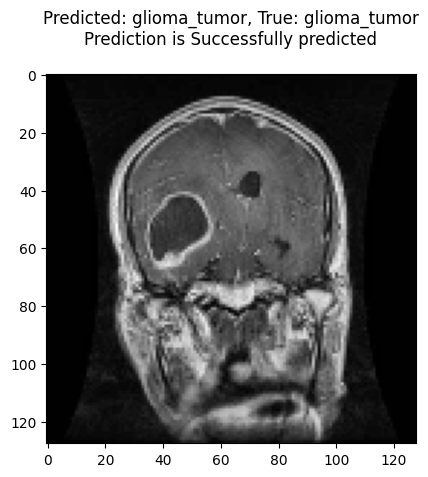

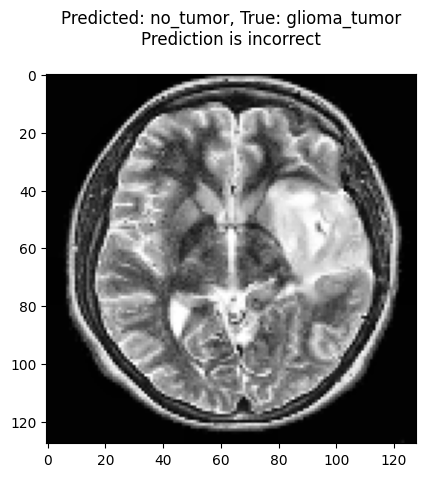

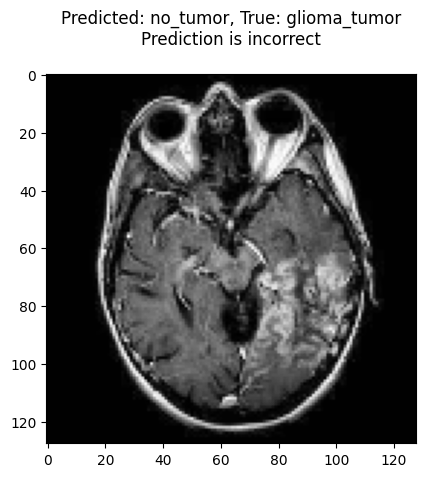

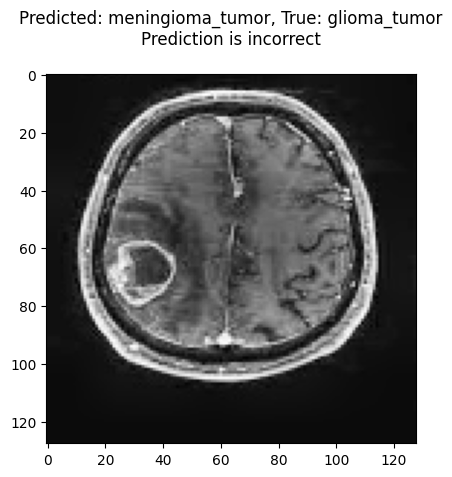

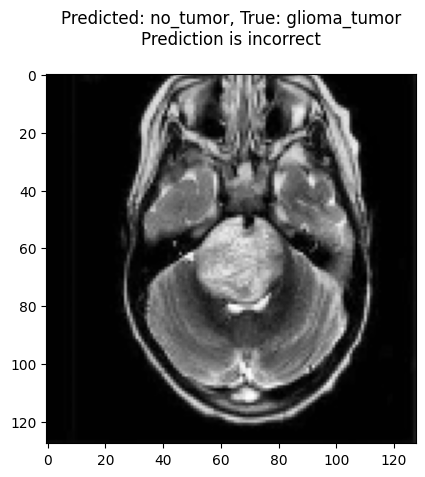

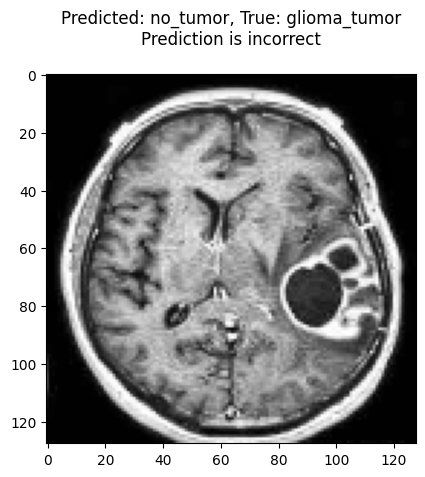

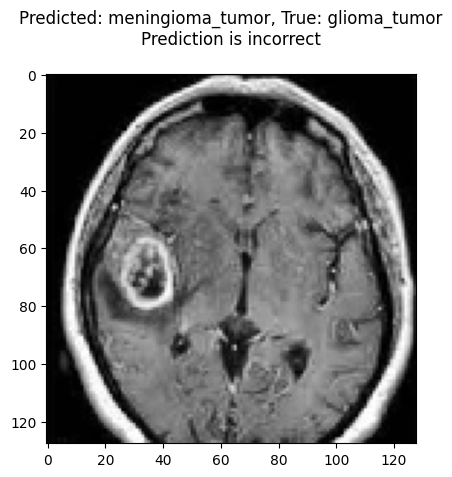

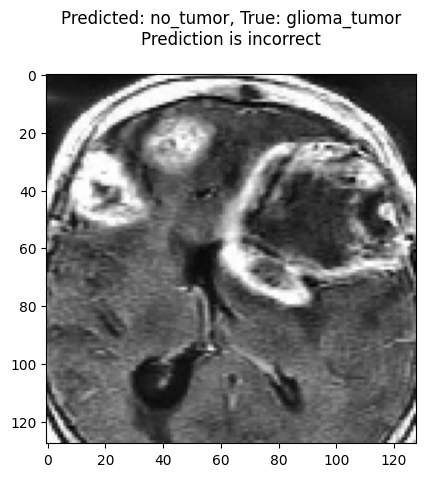

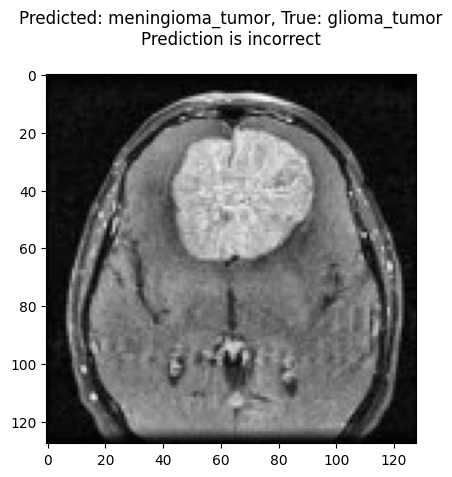

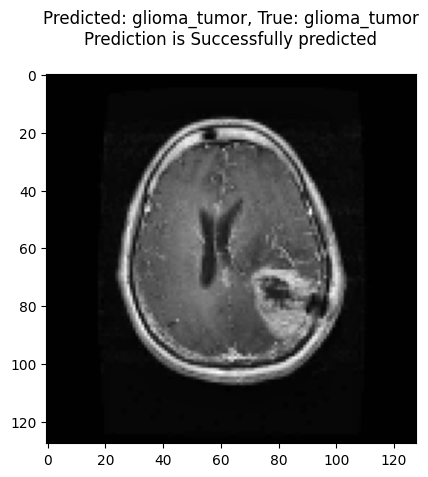

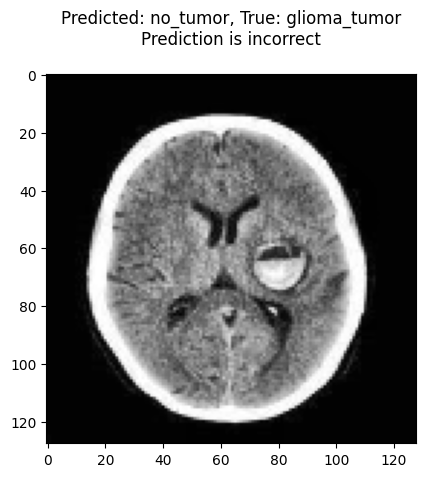

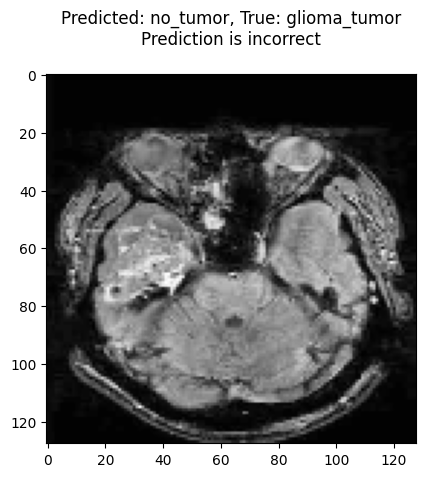

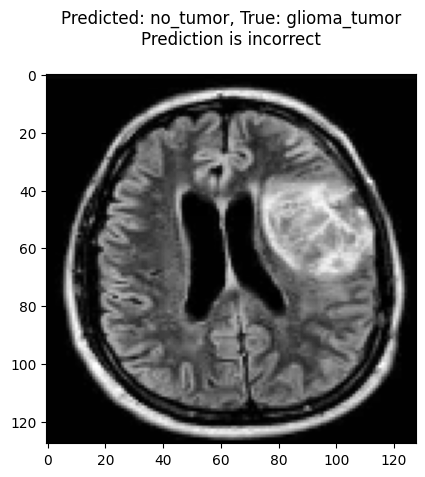

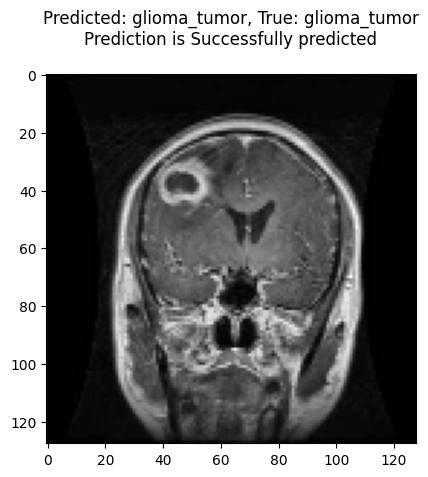

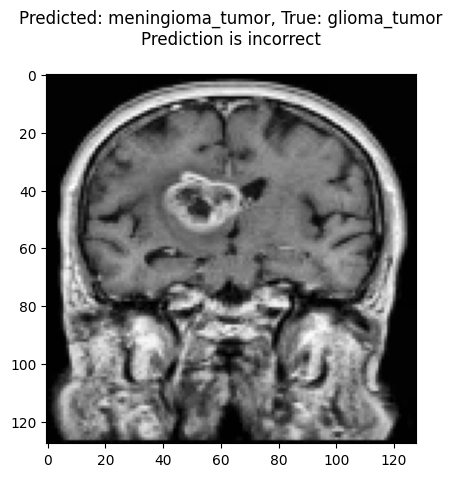

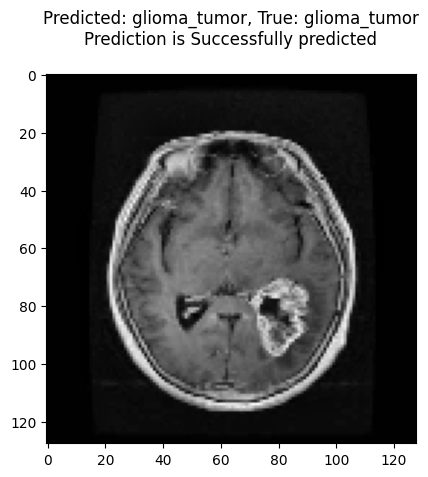

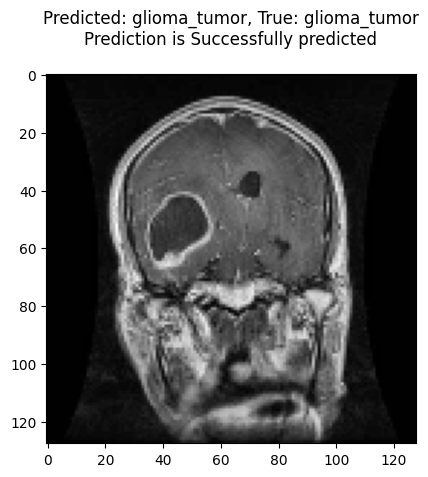

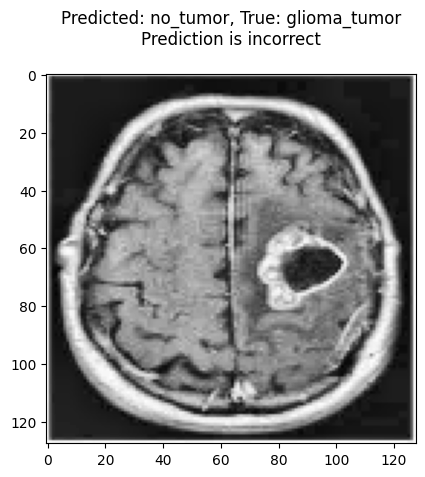

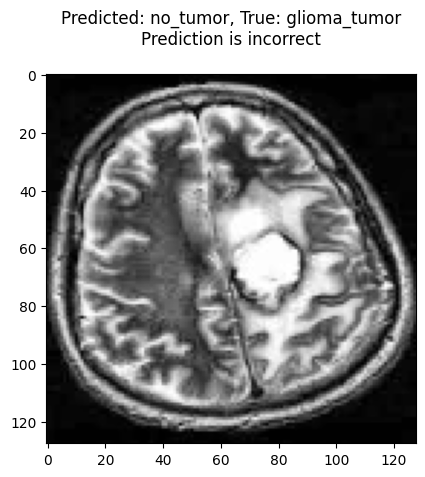

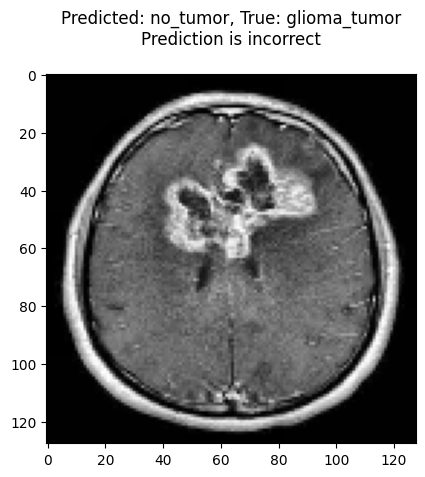

In [ ]:
def visualize_results(images, predictions, ground_truth):
  for i in range(20):
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Predicted: {predictions[i]}, True: {ground_truth[i]}\nPrediction is {'Successfully predicted' if ground_truth[i] == predictions[i] else 'incorrect'}\n")
        plt.show()

visualize_results(test_images_resized, y_pred, test_labels)
